# **Data Retrieve** 

In [164]:
import pandas as pd 
import numpy as np

## Xác định các features

Phân chia dữ liệu thành 4 loại: nominal, ordinal, discrete, missing_columns; tiện cho việc xử lí 

In [165]:
nominal = ['SUBSIDIARY_CD','GLOBAL_NO','CLASSIFY_CD','CUST_CD','BRAND_CD','INNER_CD','SUPPLIER_CD','Stock class','Consider count hodiday Saturday','OTHER AREA SHIP DIV','PRODUCT_CD','PRODUCT ATTRIBUTION','SPECIAL DIV','LOGICAL PLANT','DIRECT SHIP FLG','DELI_DIV','Ship Mode','SHIP DECISION NO','SUPPLIER_DIV','SPECIAL_DIV','QTUF_RCV_NO','SOUF_RCV_NO','Order date', 'VSD','SO_TIME']

ordinal = ['PACKING RANK']

discrete = ['Sales order line number', 'Consider count hodiday Saturday','SO QTY','ALLOCATION QTY','SUPPLIER INV AMOUNT','PURCHASE AMOUNT','PACK QTY','WEIGHT PER PIECE','SO_DAY_OF_MONTH','SO_DAY_OF_WEEK',]

missing_columns = ['OTHER AREA SHIP DIV',
 'Ship Mode',
 'SHIP DECISION NO',
 'SUPPLIER_DIV',
 'REASON_CD',
 'SOUF_RCV_NO',
 'QTUF_RCV_NO']

Các thuộc tính phi logic trong việc dự đoán delay 


In [166]:
counter_intuitive = ['Consider count hodiday Saturday', 'REASON_CD', 'VSD'] 

In [167]:
number_features = [
    'Sales order line number',
    'WEIGHT PER PIECE',
    'PURCHASE AMOUNT',
    'SO QTY',
    'ALLOCATION QTY',
    'PACK QTY',
    'SUPPLIER INV AMOUNT'
]

## Merging dataset

In [168]:
df_not_delay_7_9 = pd.read_csv('dataset/not_delay_7_9_CONDITION_PRODUCT_SUPPLIER.csv')
df_not_delay_4_6 = pd.read_csv('dataset/not_delay_4_6_CONDITION_PRODUCT_SUPPLIER.csv')
df_delay_7_9 = pd.read_csv('dataset/delay_7_9_CONDITION_PRODUCT_SUPPLIER.csv')
df_delay_4_6 = pd.read_csv('dataset/delay_4_6_CONDITION_PRODUCT_SUPPLIER.csv')

In [169]:
features = df_not_delay_7_9.columns

## Filtering features from 7_9


Lấy bộ df_7_9 làm chuẩn cho bộ 4_6

In [170]:
df_not_delay_4_6 = df_not_delay_4_6[features]
df_delay_4_6 = df_delay_4_6[features]

In [171]:
full_data_4_6 = pd.concat([df_delay_4_6, df_not_delay_4_6], axis=0)
full_data_7_9 = pd.concat([df_delay_7_9, df_not_delay_7_9], axis=0)

In [172]:
full_data_4_6.columns

Index(['Order date', 'SUBSIDIARY_CD', 'GLOBAL_NO', 'CLASSIFY_CD', 'CUST_CD',
       'BRAND_CD', 'INNER_CD', 'SUPPLIER_CD', 'Sales order line number',
       'Stock class', 'Consider count hodiday Saturday', 'SO QTY',
       'OTHER AREA SHIP DIV', 'ALLOCATION QTY', 'SUPPLIER INV AMOUNT',
       'PACKING RANK', 'PRODUCT_CD', 'PRODUCT ATTRIBUTION', 'SPECIAL DIV',
       'LOGICAL PLANT', 'PURCHASE AMOUNT', 'VSD', 'DIRECT SHIP FLG',
       'DELI_DIV', 'label', 'Ship Mode', 'SHIP DECISION NO', 'PACK QTY',
       'WEIGHT PER PIECE', 'SUPPLIER_DIV', 'SPECIAL_DIV', 'SO_DAY_OF_MONTH',
       'SO_DAY_OF_WEEK', 'REASON_CD', 'SOUF_RCV_NO', 'QTUF_RCV_NO', 'SO_TIME'],
      dtype='object')

In [173]:
full_data_4_6.shape

(399053, 37)

## Ratio detecting

Xác định tỉ lệ giữa label 0:1 

In [174]:
ratio_label_0 = (full_data_4_6['label'] == 0).sum() / full_data_4_6['label'].count()
print(f"Tỷ lệ label == 0: {ratio_label_0:.2%}")

ratio_label_1 = (full_data_4_6['label'] == 1).sum() / full_data_4_6['label'].count()
print(f"Tỷ lệ label == 1: {ratio_label_1:.2%}")

print(f"Tỉ lệ 0-1: {ratio_label_0/ratio_label_1:.0f}:1")


Tỷ lệ label == 0: 97.56%
Tỷ lệ label == 1: 2.44%
Tỉ lệ 0-1: 40:1


# **Detect outliers**

In [175]:
def detect_outliers_iqr(df, column):
    """
    Phát hiện outliers và kiểm tra giá trị âm trong một cột số bằng IQR.

    Returns:
        outliers_df (pd.DataFrame): Các dòng chứa outliers.
        outlier_indices (list): Danh sách index của outliers.
        lower_bound (float): Ngưỡng dưới.
        upper_bound (float): Ngưỡng trên.
        negative_indices (list): Danh sách index của các giá trị âm.
    """
    data = df[column]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask_outliers = (data < lower_bound) | (data > upper_bound)
    outliers_df = df[mask_outliers]
    outlier_indices = df[mask_outliers].index.tolist()

    negative_indices = df[data < 0].index.tolist()

    return outlier_indices


In [176]:
def remove_outliers_iqr(df1, df2, num_columns):
    """
    Loại bỏ outliers trong df1 và df2 dựa trên các cột số của từng dataframe.
    
    Args:
        df1 (pd.DataFrame): Dữ liệu gốc (ví dụ: tháng 4-6).
        df2 (pd.DataFrame): Dữ liệu cần clean tương ứng (ví dụ: tháng 7-9).
        num_columns (list): Danh sách các cột số để xét outliers.
    
    Returns:
        df1_cleaned (pd.DataFrame): df1 sau khi loại bỏ outliers.
        df2_cleaned (pd.DataFrame): df2 sau khi loại bỏ các dòng tương ứng.
        all_outlier_indices_4_6 (set): Index bị loại bỏ từ df1.
        all_outlier_indices_7_9 (set): Index bị loại bỏ từ df2.
    """
    all_outlier_indices_4_6 = set()
    all_outlier_indices_7_9 = set()
    
    for col in num_columns:
        outlier_indices_4_6 = detect_outliers_iqr(df1, col)
        outlier_indices_7_9 = detect_outliers_iqr(df2, col)

        all_outlier_indices_4_6.update(outlier_indices_4_6)
        all_outlier_indices_7_9.update(outlier_indices_7_9)

    df1_cleaned = df1.drop(index=all_outlier_indices_4_6)
    df2_cleaned = df2.drop(index=all_outlier_indices_7_9)

    print(f"✅ Số dòng đã loại bỏ trong df1: {len(all_outlier_indices_4_6)}")
    print(f"✅ Số dòng đã loại bỏ trong df2: {len(all_outlier_indices_7_9)}")
    
    return df1_cleaned, df2_cleaned, all_outlier_indices_4_6, all_outlier_indices_7_9


In [177]:
full_data_4_6_cleaned, full_data_7_9_cleaned, all_outlier_indices_4_6, all_outlier_indices_7_9 = remove_outliers_iqr(full_data_4_6, full_data_7_9, number_features)

✅ Số dòng đã loại bỏ trong df1: 150177
✅ Số dòng đã loại bỏ trong df2: 408951


In [178]:
full_data_4_6.shape

(399053, 37)

In [179]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_percentage_bar(
    df,
    column,
    figsize=(12, 6),
    bar_color='#00C1B5',
    edge_color='black',
    bins=10
):
    """
    Vẽ biểu đồ phần trăm cho cột, hỗ trợ chia bin nếu là số.

    Parameters:
        df (pd.DataFrame): Dữ liệu đầu vào
        column (str): Tên cột cần vẽ
        figsize (tuple): Kích thước biểu đồ
        bar_color (str): Màu cột
        edge_color (str): Màu viền
        bins (int or list): Số lượng bin hoặc danh sách bin
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=figsize)

    # Phân loại hoặc nhóm bin
    if pd.api.types.is_numeric_dtype(df[column]):
        binned = pd.cut(df[column], bins=bins, include_lowest=True)
        counts = binned.value_counts().sort_index()
        labels = [f"{int(b.left)} - {int(b.right)}" for b in counts.index]
    else:
        counts = df[column].value_counts().sort_index()
        labels = counts.index.astype(str)

    percent = (counts / counts.sum()) * 100

    bars = plt.bar(labels, percent.values, color=bar_color, edgecolor=edge_color, width=0.7)

    # Ghi nhãn phần trăm trên mỗi cột
    for bar, pct in zip(bars, percent.values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            f'{pct:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

    # Giao diện
    plt.title(f'Percentage Distribution of "{column}"', fontsize=14, weight='bold')
    plt.ylabel('Percentage (%)')
    plt.xlabel(f'{column} {"(binned)" if pd.api.types.is_numeric_dtype(df[column]) else ""}')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, percent.max() * 1.2)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


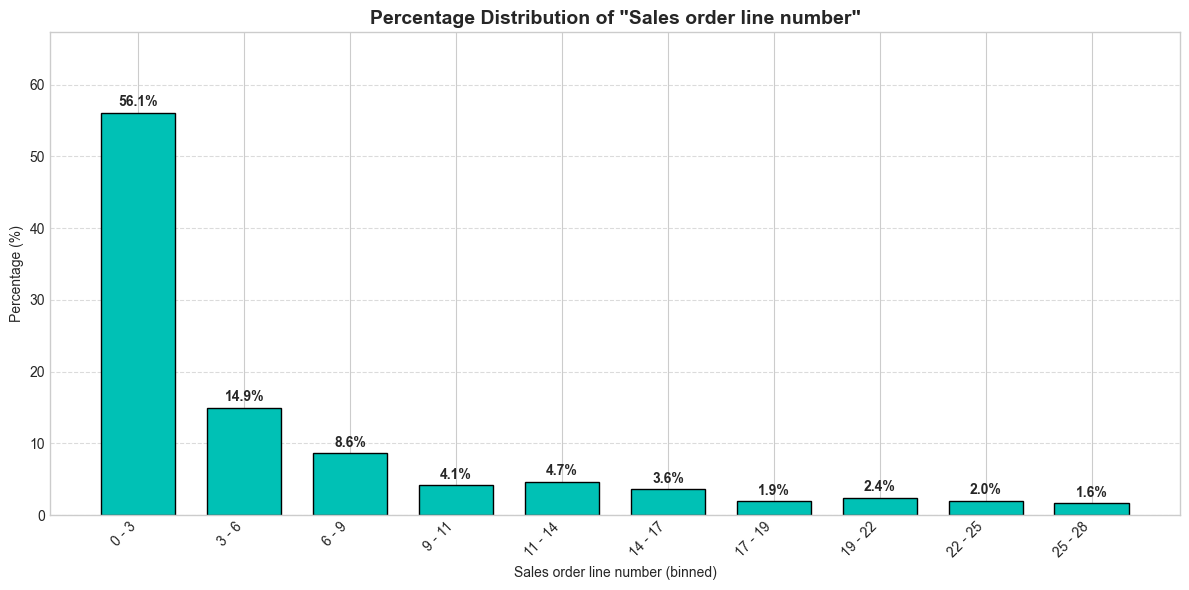

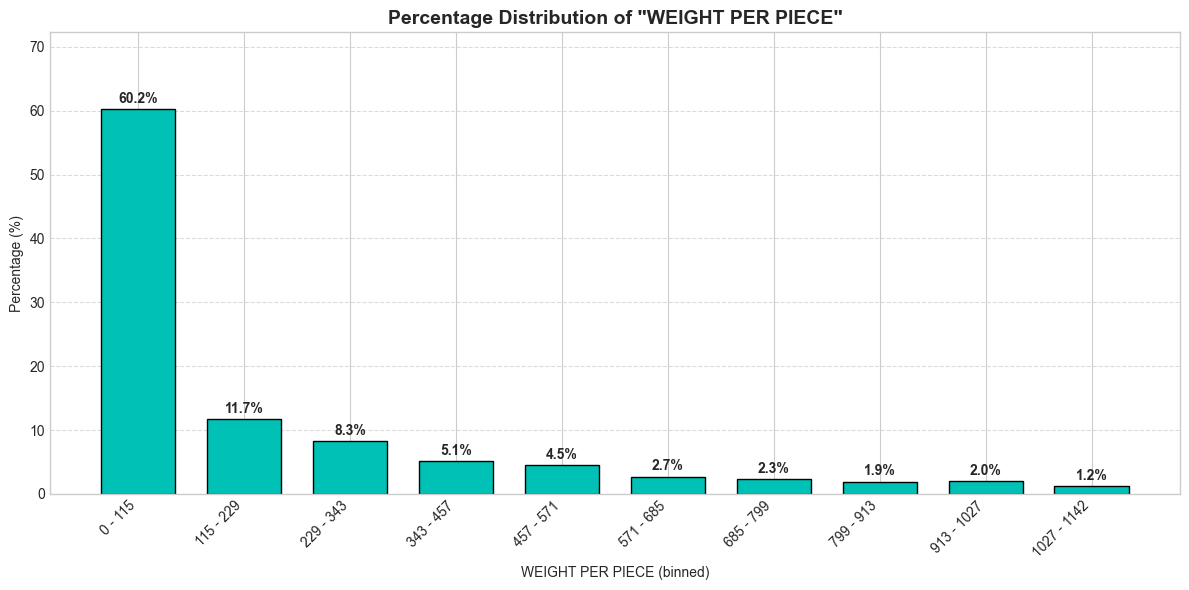

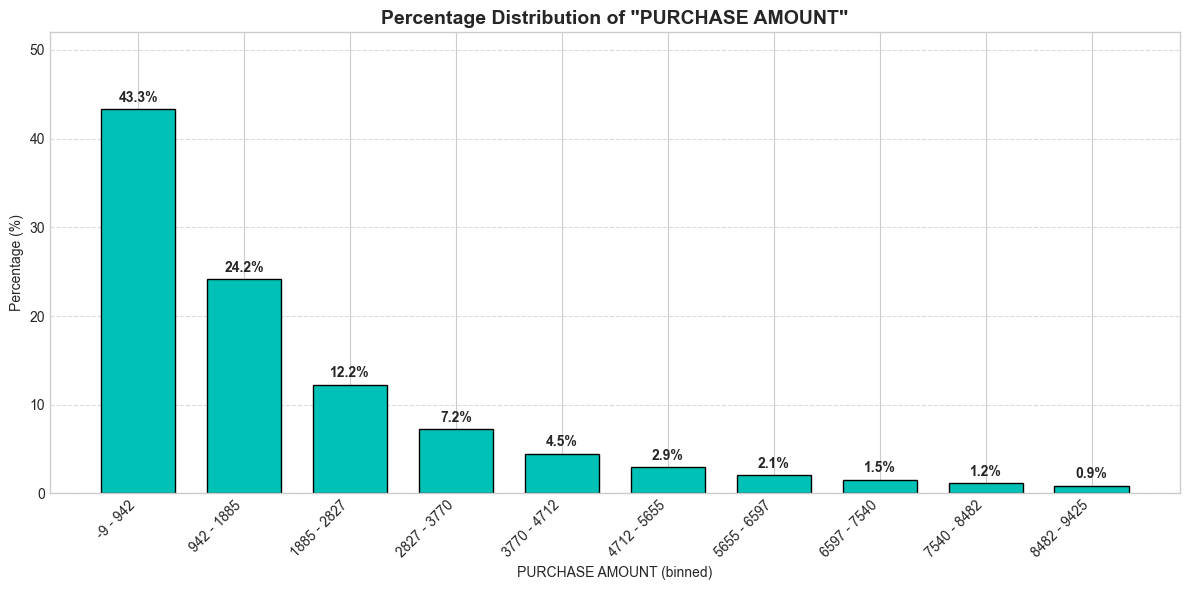

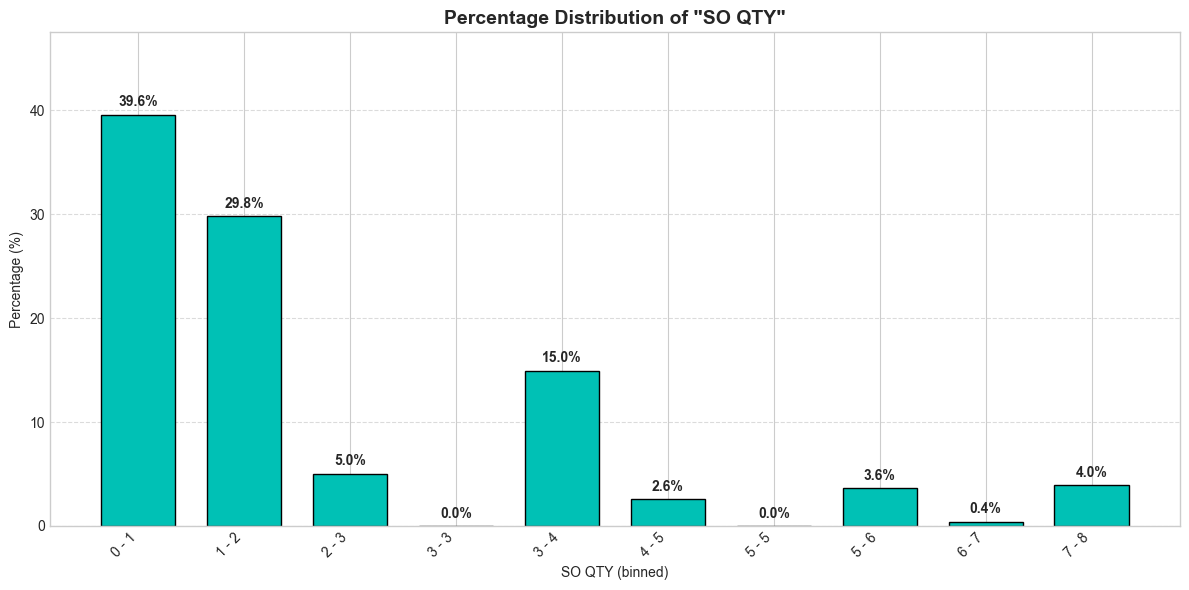

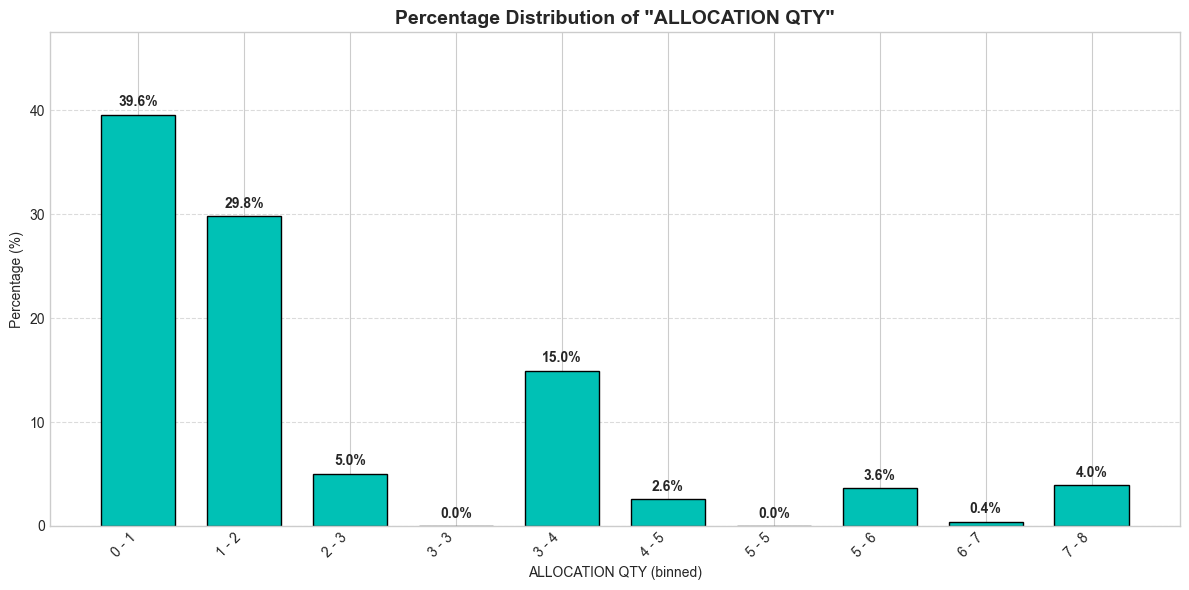

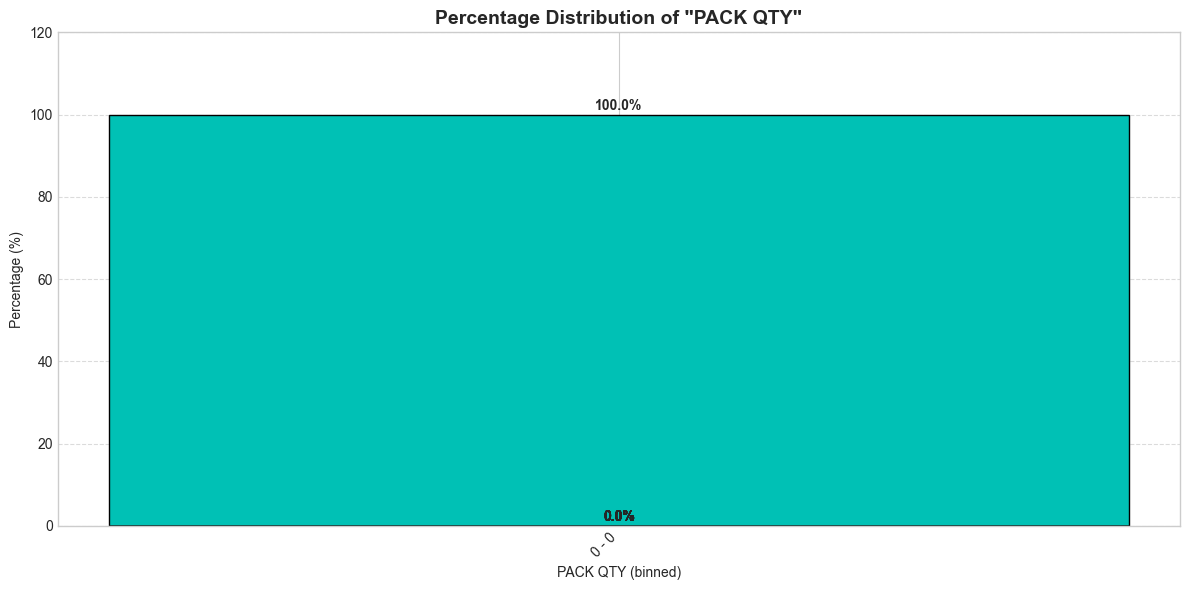

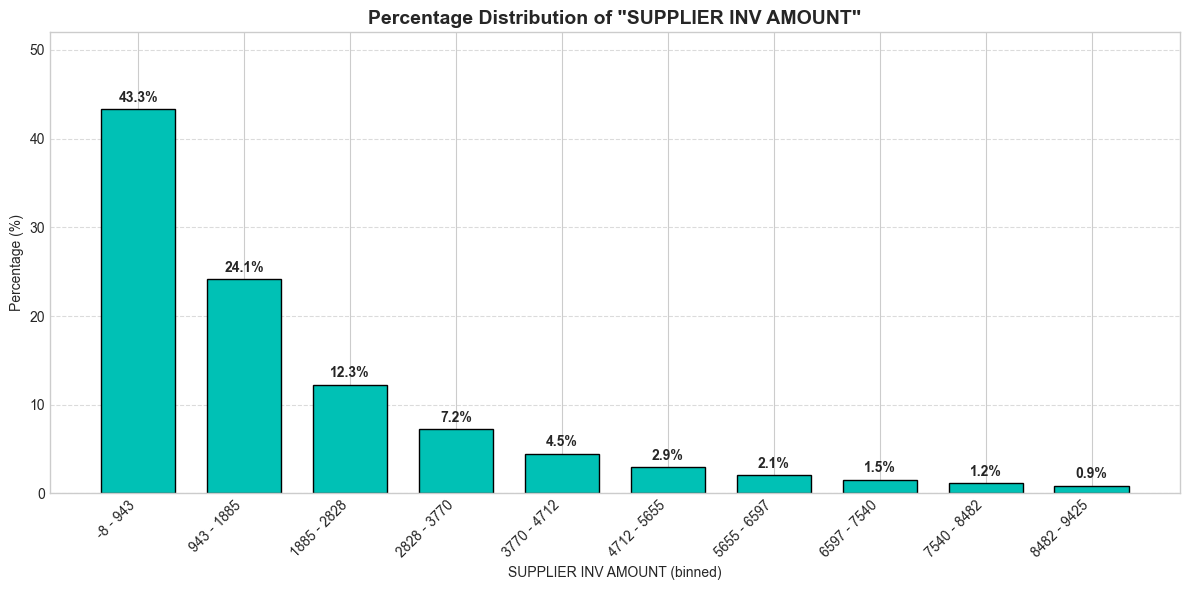

In [180]:
for feature in number_features:
    plot_percentage_bar(full_data_4_6_cleaned, feature)

# **Visualize**

## Vẽ các giá trị có unique dưới 30, so sánh với target

<Figure size 4000x400 with 0 Axes>

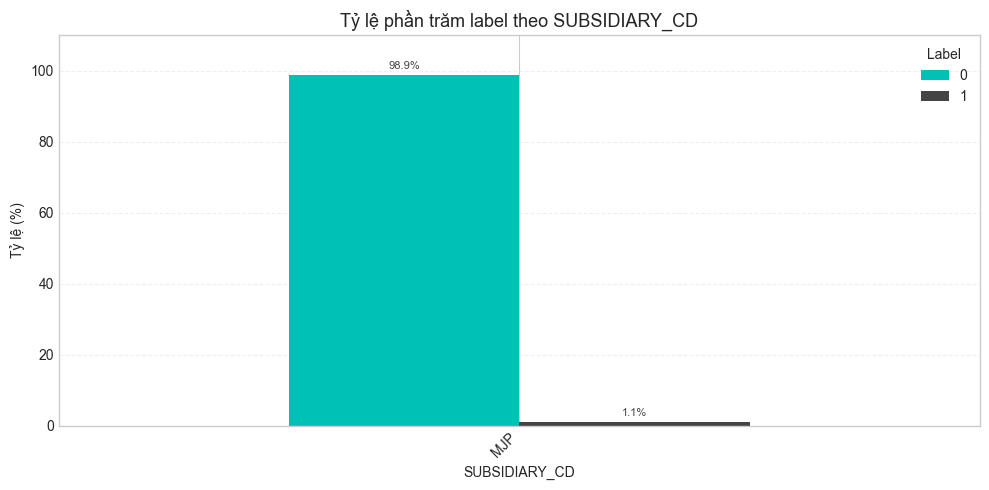

<Figure size 4000x400 with 0 Axes>

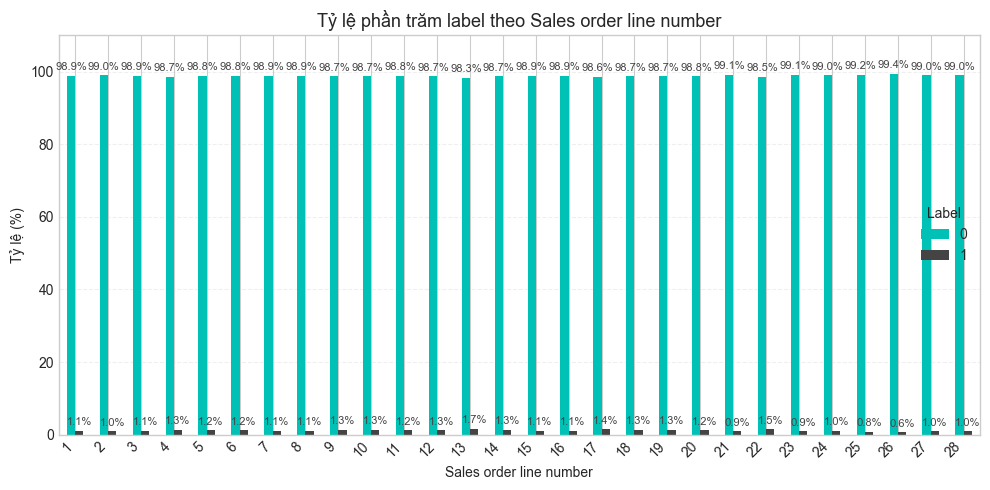

<Figure size 4000x400 with 0 Axes>

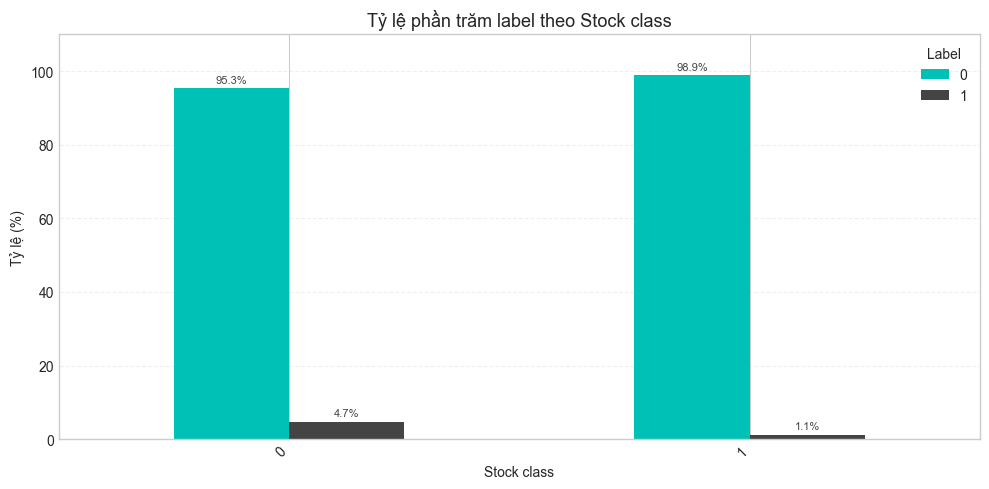

<Figure size 4000x400 with 0 Axes>

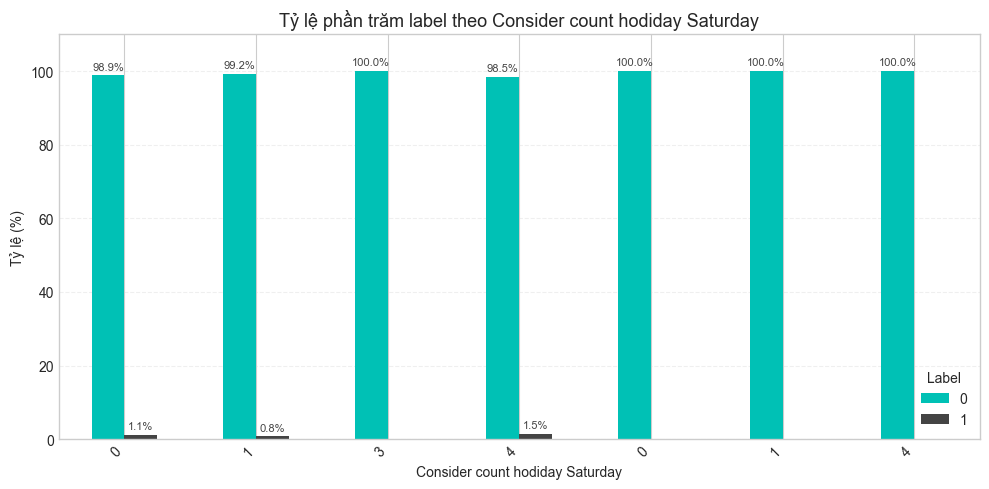

<Figure size 4000x400 with 0 Axes>

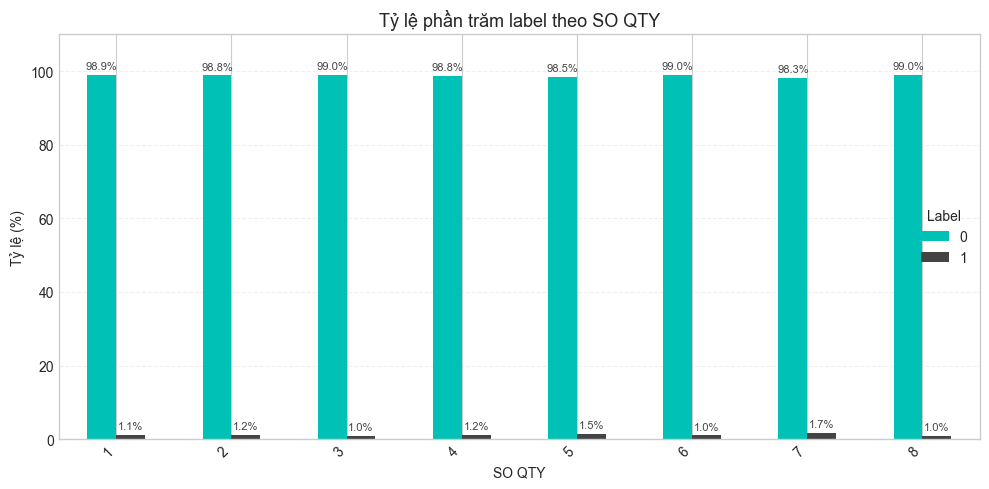

<Figure size 4000x400 with 0 Axes>

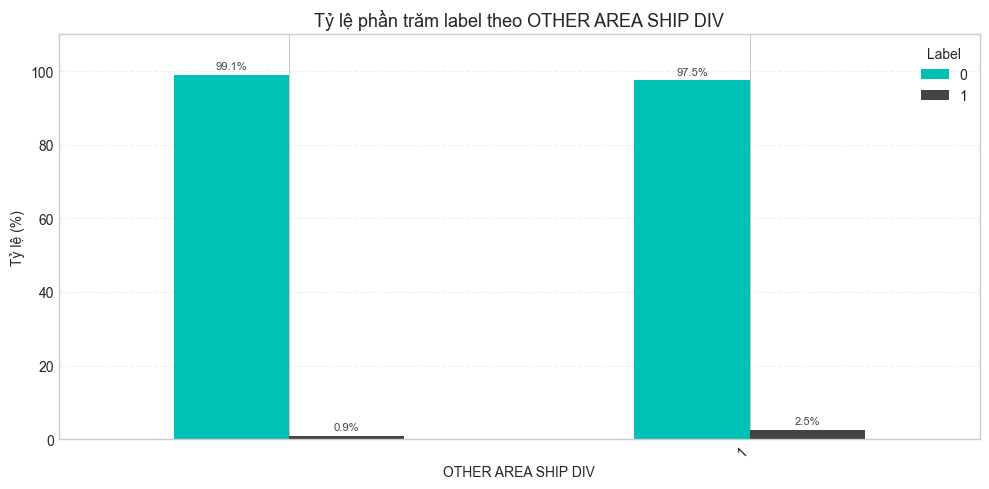

<Figure size 4000x400 with 0 Axes>

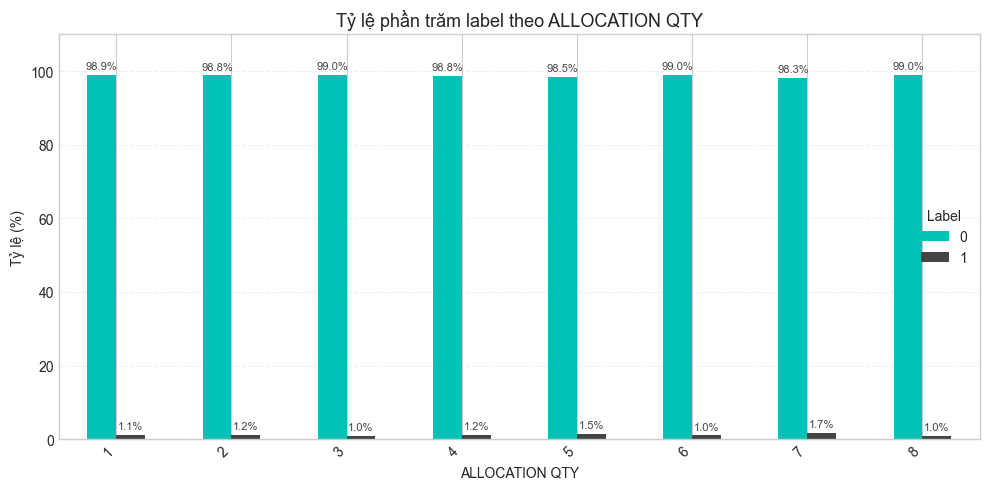

<Figure size 4000x400 with 0 Axes>

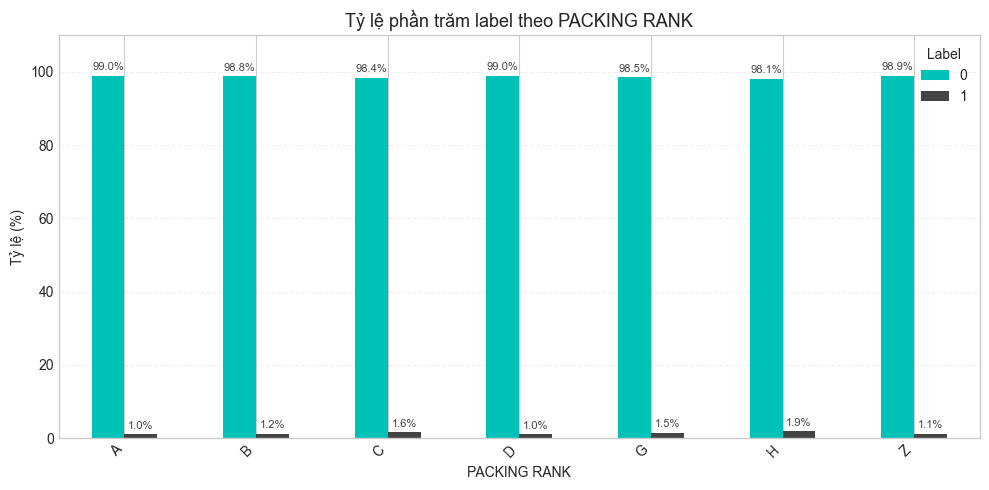

<Figure size 4000x400 with 0 Axes>

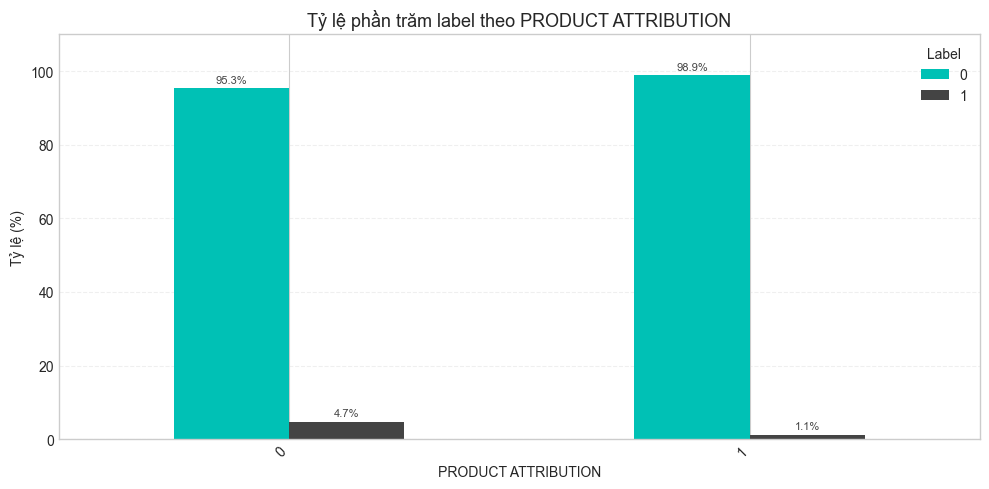

<Figure size 4000x400 with 0 Axes>

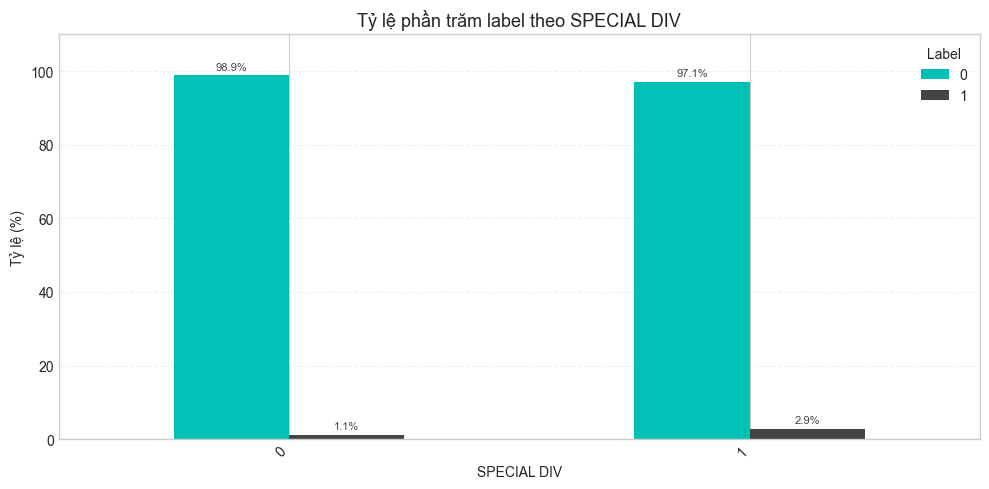

<Figure size 4000x400 with 0 Axes>

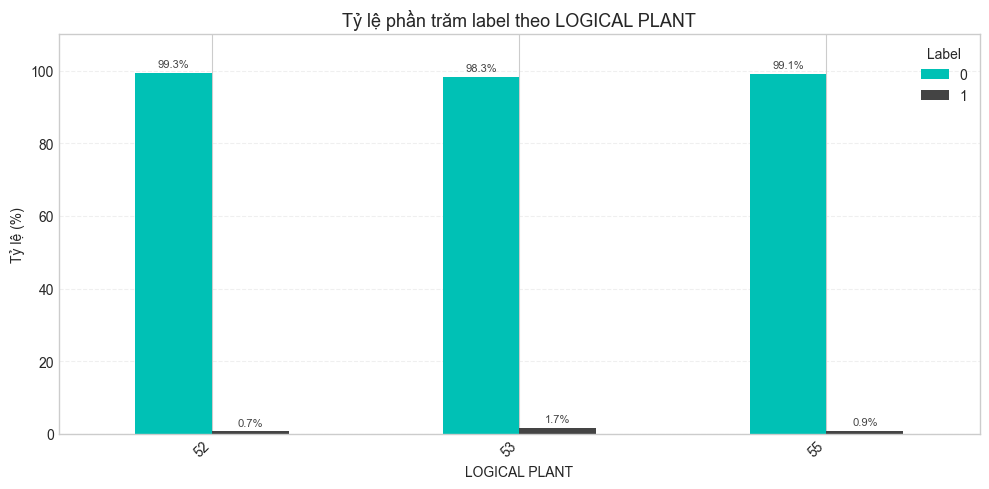

<Figure size 4000x400 with 0 Axes>

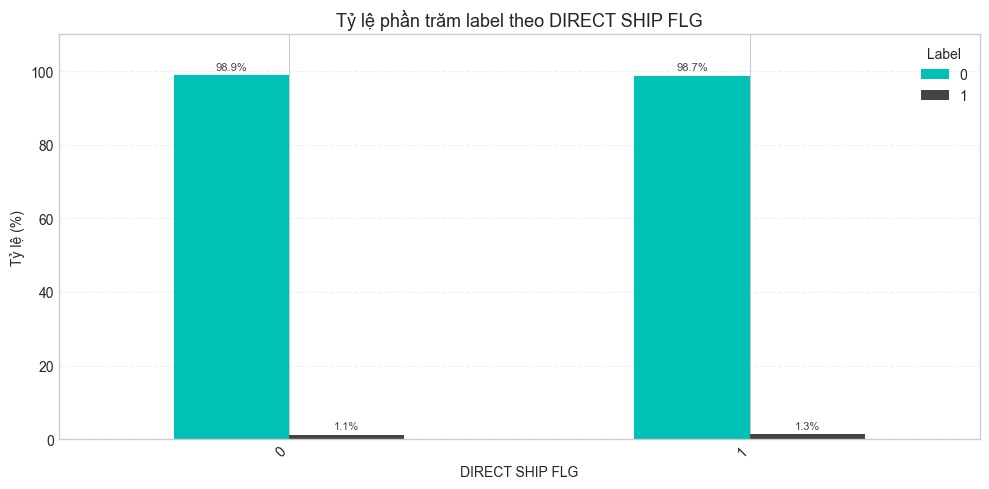

<Figure size 4000x400 with 0 Axes>

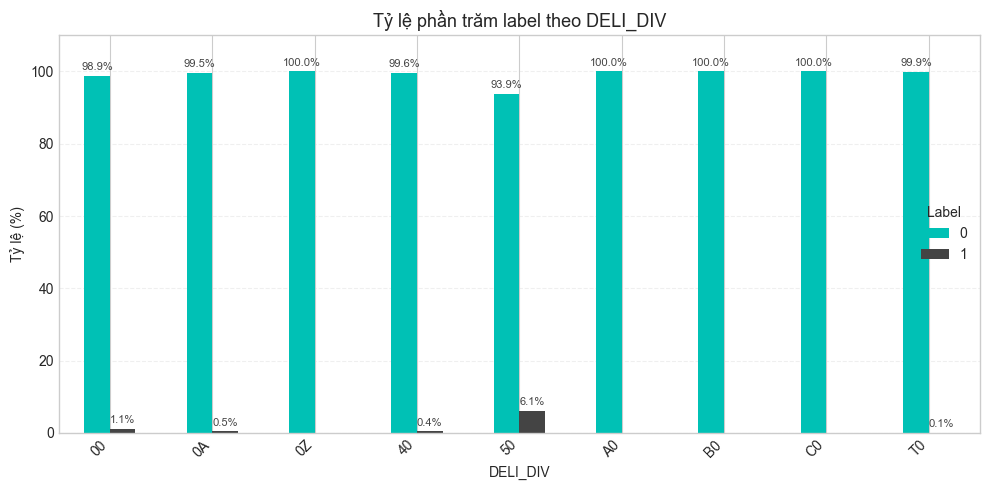

<Figure size 4000x400 with 0 Axes>

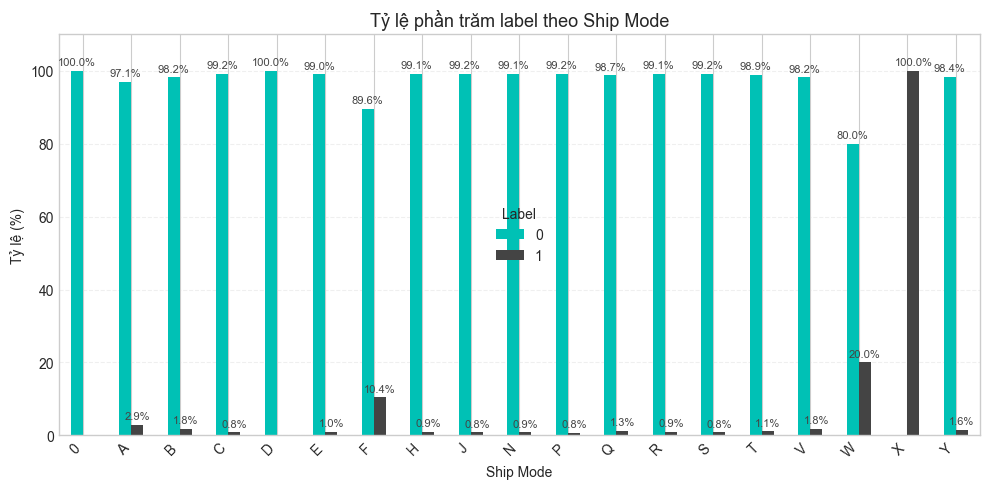

<Figure size 4000x400 with 0 Axes>

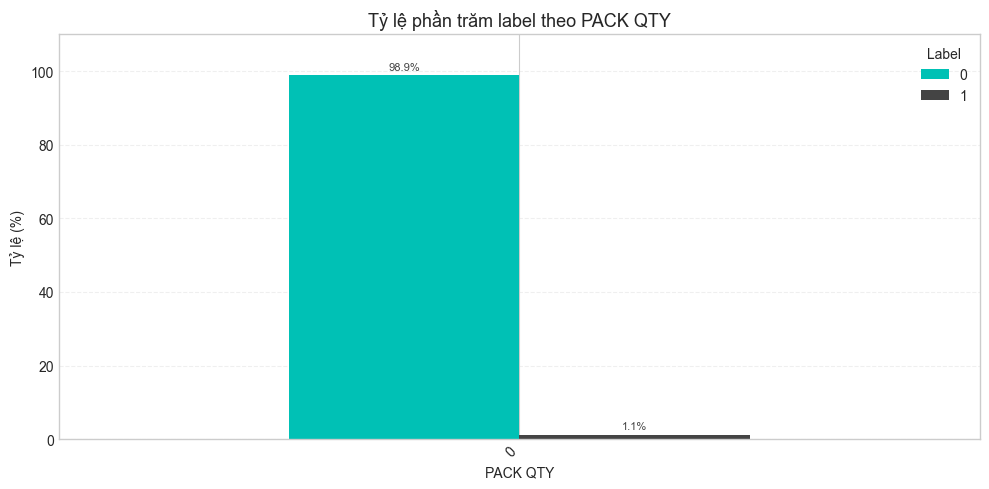

<Figure size 4000x400 with 0 Axes>

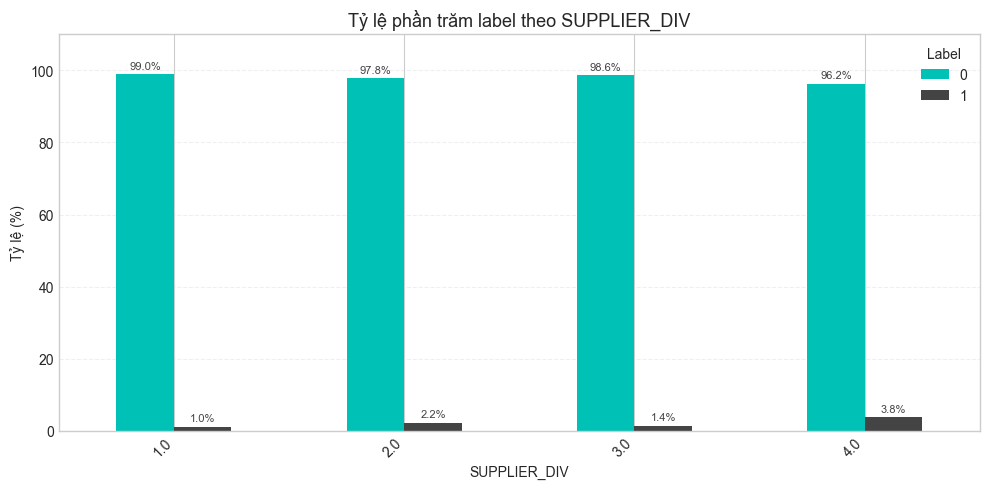

<Figure size 4000x400 with 0 Axes>

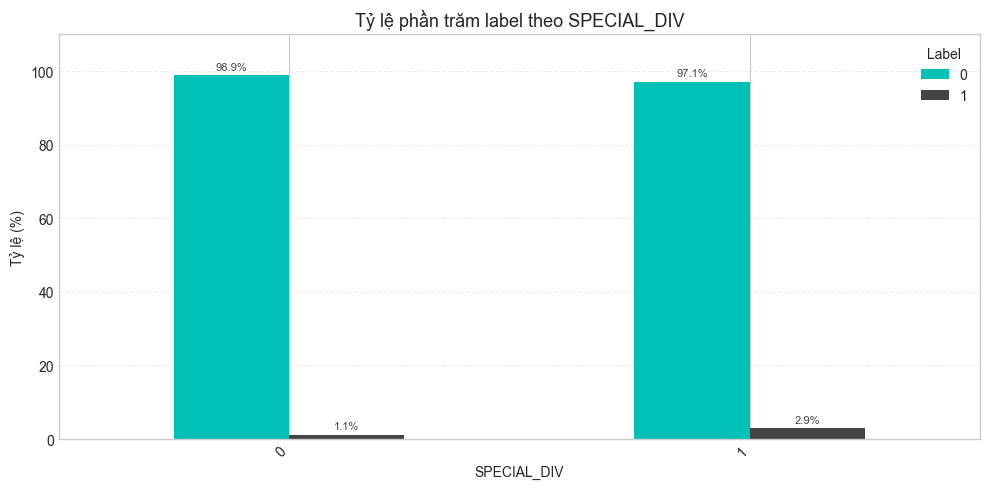

<Figure size 4000x400 with 0 Axes>

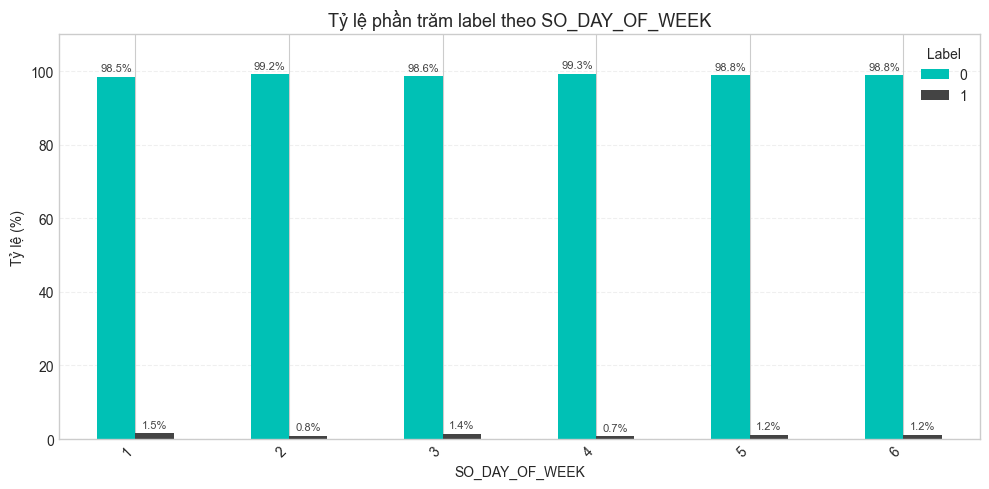

In [181]:
import matplotlib.pyplot as plt
import pandas as pd

# Ngưỡng lọc số lượng unique < 100
threshold = 30
low_card_cols = [col for col in full_data_4_6_cleaned.columns if full_data_4_6_cleaned[col].nunique() < threshold and col != 'label']

# Tone màu tài chính - bảo hiểm
colors = ['#00C1B5', '#444444']  # label 0, label 1

# Vẽ biểu đồ theo phần trăm
for col in low_card_cols:
    plt.figure(figsize=(40, 4))
    
    # Tính phần trăm label theo từng giá trị của cột
    count_df = full_data_4_6_cleaned.groupby([col, 'label']).size().unstack(fill_value=0)
    percent_df = count_df.div(count_df.sum(axis=1), axis=0) * 100
    
    # Vẽ biểu đồ
    ax = percent_df.plot(kind='bar', stacked=False, color=colors, figsize=(10, 5))
    
    plt.title(f'Tỷ lệ phần trăm label theo {col}', fontsize=13)
    plt.xlabel(col)
    plt.ylabel('Tỷ lệ (%)')
    plt.ylim(0, 110)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Label')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # Hiển thị phần trăm trên cột
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 1,
                    f'{height:.1f}%',
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    color='#444444'
                )
    
    plt.show()


Xét lần lượt các feature: 
- `SUBSIDIARY_CD`: Mọi sample dữ liệu đều có nên em quyết định bỏ feature

- `Stock class`: Với stock class 0, tỉ lệ label 1 là 4.8% và khi stock class 1, tỉ lệ label 0 là 2.4%. => Đối với các đơn hàng tồn kho loại 0 sẽ có xu hướng delay cao hơn so với loại 1

- `Consider count holiday Saturday`: Với số ngày 0,1,4 sẽ có nguy cơ delay với lần lượt tỉ lệ là 2.3%, 2.9%, 3.3% => càng nhiều ngày thì nguy cơ delay càng cao. Nhưng ở ngày thứ 3 lại không có dữ liệu delay, có thể suy đoán data đã bị chỉnh sửa hoặc bị thiếu.

- `OTHER AREA SHIP DIV`: Nếu vận chuyển ở khu vực khác (1) nguy cơ bị delay sẽ cao hơn 2,5% so với vận chuyển nội bộ.

- `PACKING RANK`: Với các rank A, B, C tỉ lệ delay lần lượt là 2%, 2.6%, 2.8%. Với rank G, H, Z tỉ lệ delay lần lượt là 3.3%, 3.1%, 2.5%. Đặc biệt D có tỉ lệ delay thấp hơn hẳn với 1.5%

- `PRODUCT ATTRIBUTION`: Sản phẩm tồn kho (1) sẽ có xu hướng ít delay hơn sản phẩm phải sản xuất (0) với tỉ lệ lần lượt là 2.4%, 4.8%

- `SPECIAL DIV`: Với tiêu chuẩn 1 sẽ có tỉ lệ delay cao hơn gấp đôi so với tiêu chuẩn 0.

- `LOGICAL PLANT`: Plant 53 sẽ có có tỉ lệ delay cao gấp đôi so với các tỉ lệ còn lại (3.4%)

- `DIRECT SHIP FLG`: Với flag 1 sẽ có xu hướng delay cao hơn so với flag 0 (4.1% so với 2.2%)

- `DELI_DIV`: Với phương thức vận chuyển đơn hàng 50 sẽ có khả năng delay cao nhất với tỉ lệ 13.8%, các phương thức khác lần lượt là 2.3%, 0.5%, 2.4%, 0.1%

- `Ship Mode`: Phương thức O sẽ có tỉ lệ cao nhất là 66.7% tỉ lệ delay, phương thức X sẽ là 50% delay.

Sơ lược các features có thể dùng để dự đoán

In [182]:
Potential_features = ['Stock class','OTHER AREA SHIP DIV','SPECIAL DIV','LOGICAL PLANT','DELI_DIV','Ship Mode','SUPPLIER_DIV']

In [183]:
len(Potential_features)

7

# **Chuẩn bị data cho WoE_IV**

In [184]:
df_WoE_IV = pd.concat([full_data_4_6_cleaned, full_data_7_9_cleaned], axis=0)

In [185]:
df_WoE_IV

,Order date,SUBSIDIARY_CD,GLOBAL_NO,CLASSIFY_CD,CUST_CD,BRAND_CD,INNER_CD,SUPPLIER_CD,Sales order line number,Stock class,...,PACK QTY,WEIGHT PER PIECE,SUPPLIER_DIV,SPECIAL_DIV,SO_DAY_OF_MONTH,SO_DAY_OF_WEEK,REASON_CD,SOUF_RCV_NO,QTUF_RCV_NO,SO_TIME
0,2022-04-04 00:00:00,MJP,1000074430653,21034701,74,HAK1,F7371210001,8107,1,1,...,0,12,3.0,0,4,1,401,805169,NaN,120324
3,2022-04-22 00:00:00,MJP,1000074434911,3731227,74,MSM1,79014275005,3013,1,1,...,0,43,1.0,0,22,5,410,NaN,NaN,93246
4,2022-04-22 00:00:00,MJP,1000074435036,3954111,74,MSM1,30357450001,3081,1,1,...,0,270,1.0,0,22,5,410,NaN,NaN,153401
20,2022-04-07 00:00:00,MJP,5005504006791,21013001,5504,IKO1,F1340000036,9102,24,1,...,0,1,3.0,0,7,4,451,NaN,NaN,140334
22,2022-06-03 00:00:00,MJP,1000114287020,3713545,114,MSM1,30064100001,3305,1,1,...,0,193,1.0,1,3,5,410,NaN,NaN,141231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048672,2022-09-09,MJP,01111119630418,21059785,111119,SA11,F5257957004,8106,9,1,...,0,1,3.0,0,9,5,NaN,NaN,NaN,161730
1048674,2022-07-21,MJP,MA000248033312,21030401,524046,KOG1,F7069450098,8112,1,1,...,0,24,2.0,0,21,4,NaN,NaN,NaN,174204
1048676,2022-09-30,MJP,07169222913959,3954111,169222,MSM1,30357250002,3212,9,1,...,0,648,1.0,0,30,5,NaN,NaN,NaN,134543
1048677,2022-07-29,MJP,GC00EDMR000719,3743528,251577,MSM1,30220350001,0229,4,1,...,0,33,1.0,0,29,5,NaN,NaN,NaN,182313


In [186]:
missing_columns = df_WoE_IV.columns[df_WoE_IV.isnull().any()].tolist()

In [187]:
missing_columns

['OTHER AREA SHIP DIV',
 'Ship Mode',
 'SHIP DECISION NO',
 'SUPPLIER_DIV',
 'REASON_CD',
 'SOUF_RCV_NO',
 'QTUF_RCV_NO']

# **Fill Nan**

In [188]:
import numpy as np
import pandas as pd

def clean_reason_cd_column(df, column='REASON_CD', fill_value=-1):
    """
    Làm sạch dữ liệu cho một cột trong DataFrame:
    - Thay thế các khoảng trắng bằng NaN
    - Thay NaN bằng giá trị cụ thể (mặc định là -1)
    
    Parameters:
        df (pd.DataFrame): DataFrame chứa dữ liệu cần xử lý
        column (str): Tên cột cần xử lý
        fill_value (int, float, str): Giá trị dùng để thay thế các giá trị thiếu
        
    Returns:
        pd.DataFrame: DataFrame đã được xử lý
    """
    df = df.copy()
    
    # Thay toàn bộ NaN trong DataFrame (nếu có)
    df = df.fillna(fill_value)
    
    # Thay các giá trị chuỗi khoảng trắng bằng NaN
    df.replace(" ", np.nan, inplace=True)
    df.replace("   ", np.nan, inplace=True)
    df.replace("nan", -1, inplace=True)
    df['OTHER AREA SHIP DIV'] = df['OTHER AREA SHIP DIV'].replace(" ", "-1")
    
    # Làm sạch riêng cho cột cụ thể
    if column in df.columns:
        df[column] = df[column].fillna(fill_value)
    
    return df


In [189]:
full_data_4_6['OTHER AREA SHIP DIV'] =  pd.to_numeric(full_data_4_6['OTHER AREA SHIP DIV'], errors='coerce')
full_data_7_9['OTHER AREA SHIP DIV'] =  pd.to_numeric(full_data_7_9['OTHER AREA SHIP DIV'], errors='coerce')
df_WoE_IV['OTHER AREA SHIP DIV'] =  pd.to_numeric(df_WoE_IV['OTHER AREA SHIP DIV'], errors='coerce')

full_data_4_6_cleaned['OTHER AREA SHIP DIV'] = pd.to_numeric(full_data_4_6_cleaned['OTHER AREA SHIP DIV'], errors='coerce')
full_data_7_9_cleaned['OTHER AREA SHIP DIV'] = pd.to_numeric(full_data_7_9_cleaned['OTHER AREA SHIP DIV'], errors='coerce') 

In [190]:
df_WoE_IV = clean_reason_cd_column(df_WoE_IV, column='REASON_CD', fill_value=-1)
full_data_4_6 = clean_reason_cd_column(full_data_4_6, column='REASON_CD', fill_value=-1)
full_data_7_9 = clean_reason_cd_column(full_data_7_9, column='REASON_CD', fill_value=-1)

full_data_4_6_cleaned = clean_reason_cd_column(full_data_4_6_cleaned, column='REASON_CD', fill_value=-1)
full_data_7_9_cleaned = clean_reason_cd_column(full_data_7_9_cleaned, column='REASON_CD', fill_value=-1)

In [191]:
full_data_4_6['OTHER AREA SHIP DIV'].unique()
full_data_7_9['OTHER AREA SHIP DIV'].unique()

array([ 1., -1.])

# **Datatype correcting**

In [192]:
def convert_column_types(df, nominal, ordinal):
    """
    Chuyển kiểu dữ liệu của các cột trong DataFrame:
    - Các cột trong nominal + ordinal → str
    - Các cột còn lại → int64

    Parameters:
        df (pd.DataFrame): DataFrame đầu vào.
        nominal (list): Danh sách các biến định tính (nominal).
        ordinal (list): Danh sách các biến thứ bậc (ordinal).

    Returns:
        pd.DataFrame: DataFrame sau khi chuyển kiểu dữ liệu.
    """
    df_converted = df.copy()
    for column in df_converted.columns:
        if column in nominal + ordinal:
            df_converted[column] = df_converted[column].astype(str)
        else:
            df_converted[column] = df_converted[column].astype('int64')
    return df_converted


In [193]:
df_WoE_IV = convert_column_types(df_WoE_IV, nominal, ordinal)
full_data_7_9 = convert_column_types(full_data_7_9, nominal, ordinal)
full_data_4_6 = convert_column_types(full_data_4_6, nominal, ordinal)

full_data_4_6_cleaned = convert_column_types(full_data_4_6_cleaned, nominal, ordinal)
full_data_7_9_cleaned = convert_column_types(full_data_7_9_cleaned, nominal, ordinal)

In [194]:
df_WoE_IV.info()

<class 'pandas.core.frame.DataFrame'>
Index: 887199 entries, 0 to 1048678
Data columns (total 37 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   Order date                       887199 non-null  object
 1   SUBSIDIARY_CD                    887199 non-null  object
 2   GLOBAL_NO                        887199 non-null  object
 3   CLASSIFY_CD                      887199 non-null  object
 4   CUST_CD                          887199 non-null  object
 5   BRAND_CD                         887199 non-null  object
 6   INNER_CD                         887199 non-null  object
 7   SUPPLIER_CD                      887199 non-null  object
 8   Sales order line number          887199 non-null  int64 
 9   Stock class                      887199 non-null  object
 10  Consider count hodiday Saturday  887199 non-null  object
 11  SO QTY                           887199 non-null  int64 
 12  OTHER AREA SHIP DIV 

# **Multicollinear Processing**

## Sử dụng WoE và IV cho feature selection: https://www.kaggle.com/code/chandrimad31/credit-risk-part-1-binning-woe-iv-pd-model#Binning,-Weight-of-Evidence-(WoE),-Information-Value-(IV)

In [195]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    cols = data.columns
    
    #Run WoE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        if show_woe == True:
            print(d)
            
    return newDF, woeDF

iv, woe = iv_woe(df_WoE_IV, target='label')

Information value of Order date is 0.657039
Information value of SUBSIDIARY_CD is 0.0
Information value of GLOBAL_NO is 210.655796
Information value of CLASSIFY_CD is 2.073175
Information value of CUST_CD is 8.632094
Information value of BRAND_CD is 0.542129
Information value of INNER_CD is 33.156938
Information value of SUPPLIER_CD is 1.720305
Information value of Sales order line number is 0.003026
Information value of Stock class is 0.005807
Information value of Consider count hodiday Saturday is 0.063721
Information value of SO QTY is 0.003773
Information value of OTHER AREA SHIP DIV is 0.094359
Information value of ALLOCATION QTY is 0.003773
Information value of SUPPLIER INV AMOUNT is 0.062821
Information value of PACKING RANK is 0.002485
Information value of PRODUCT_CD is 139.927992
Information value of PRODUCT ATTRIBUTION is 0.005807
Information value of SPECIAL DIV is 0.017274
Information value of LOGICAL PLANT is 0.039852
Information value of PURCHASE AMOUNT is 0.062707
Inform

In [196]:
iv.sort_values(by='IV', ascending=False, inplace=True)
iv

,Variable,IV
0,GLOBAL_NO,210.655796
0,PRODUCT_CD,139.927992
0,SHIP DECISION NO,89.442798
0,INNER_CD,33.156938
0,CUST_CD,8.632094
0,SOUF_RCV_NO,5.625553
0,SO_TIME,4.233027
0,CLASSIFY_CD,2.073175
0,SUPPLIER_CD,1.720305
0,VSD,1.438217


**Encode Ordinal**

In [197]:
from sklearn.preprocessing import OrdinalEncoder

def apply_ordinal_encoding(df, ordinal_columns):
    """
    Mã hóa các cột ordinal theo thứ tự cho trước và ép kiểu thành int.

    Parameters:
        df (pd.DataFrame): DataFrame gốc.
        ordinal_columns (list): Danh sách tên các cột ordinal cần mã hóa.
        ranking (list): Thứ tự ưu tiên, ví dụ: ['A','B','C','D','H','G','Z']

    Returns:
        pd.DataFrame: DataFrame với các cột ordinal đã được mã hóa.
    """
    ranking = ['A','B','C','D','H','G','Z']
    # Lặp lại ranking cho từng cột (nếu tất cả dùng chung thứ tự)
    categories = [ranking] * len(ordinal_columns)

    encoder = OrdinalEncoder(categories=categories)
    df[ordinal_columns] = encoder.fit_transform(df[ordinal_columns])
    df[ordinal_columns] = df[ordinal_columns].astype('int')

    return df

In [198]:
df_WoE_IV = apply_ordinal_encoding(df_WoE_IV, ordinal)

## Dùng spearman cho các thuộc tính category có thứ tự

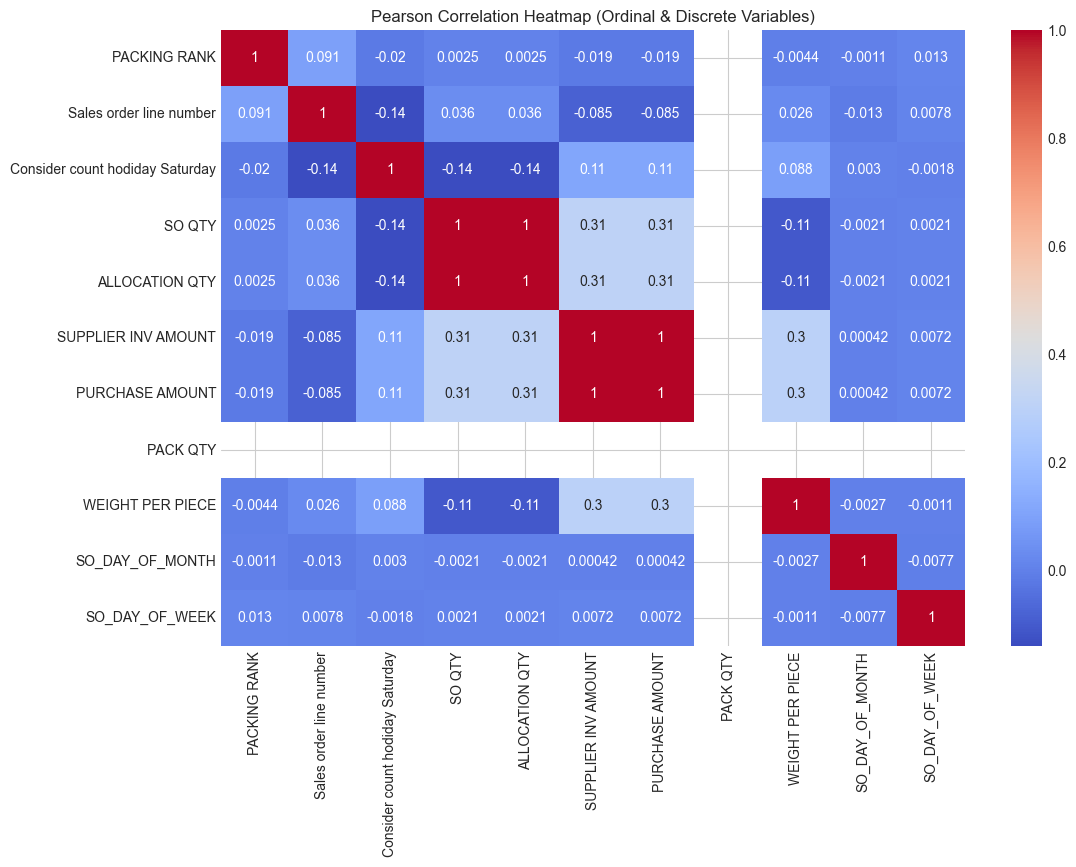

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns
# Lọc các cột ordinal và discrete
ordinal_discrete_columns = ordinal + discrete

# Tính ma trận Pearson correlation
pearson_correlation_matrix = df_WoE_IV[ordinal_discrete_columns].corr(method='spearman')

# Vẽ heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pearson_correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Pearson Correlation Heatmap (Ordinal & Discrete Variables)")
plt.show()

## Label nominal data để sử dụng Cramer's V

In [200]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
# Áp dụng LabelEncoder cho các cột 'VSD' và 'Order date'
df_WoE_IV['VSD'] = label_encoder.fit_transform(df_WoE_IV['VSD'])
df_WoE_IV['Order date'] = label_encoder.fit_transform(df_WoE_IV['Order date'])

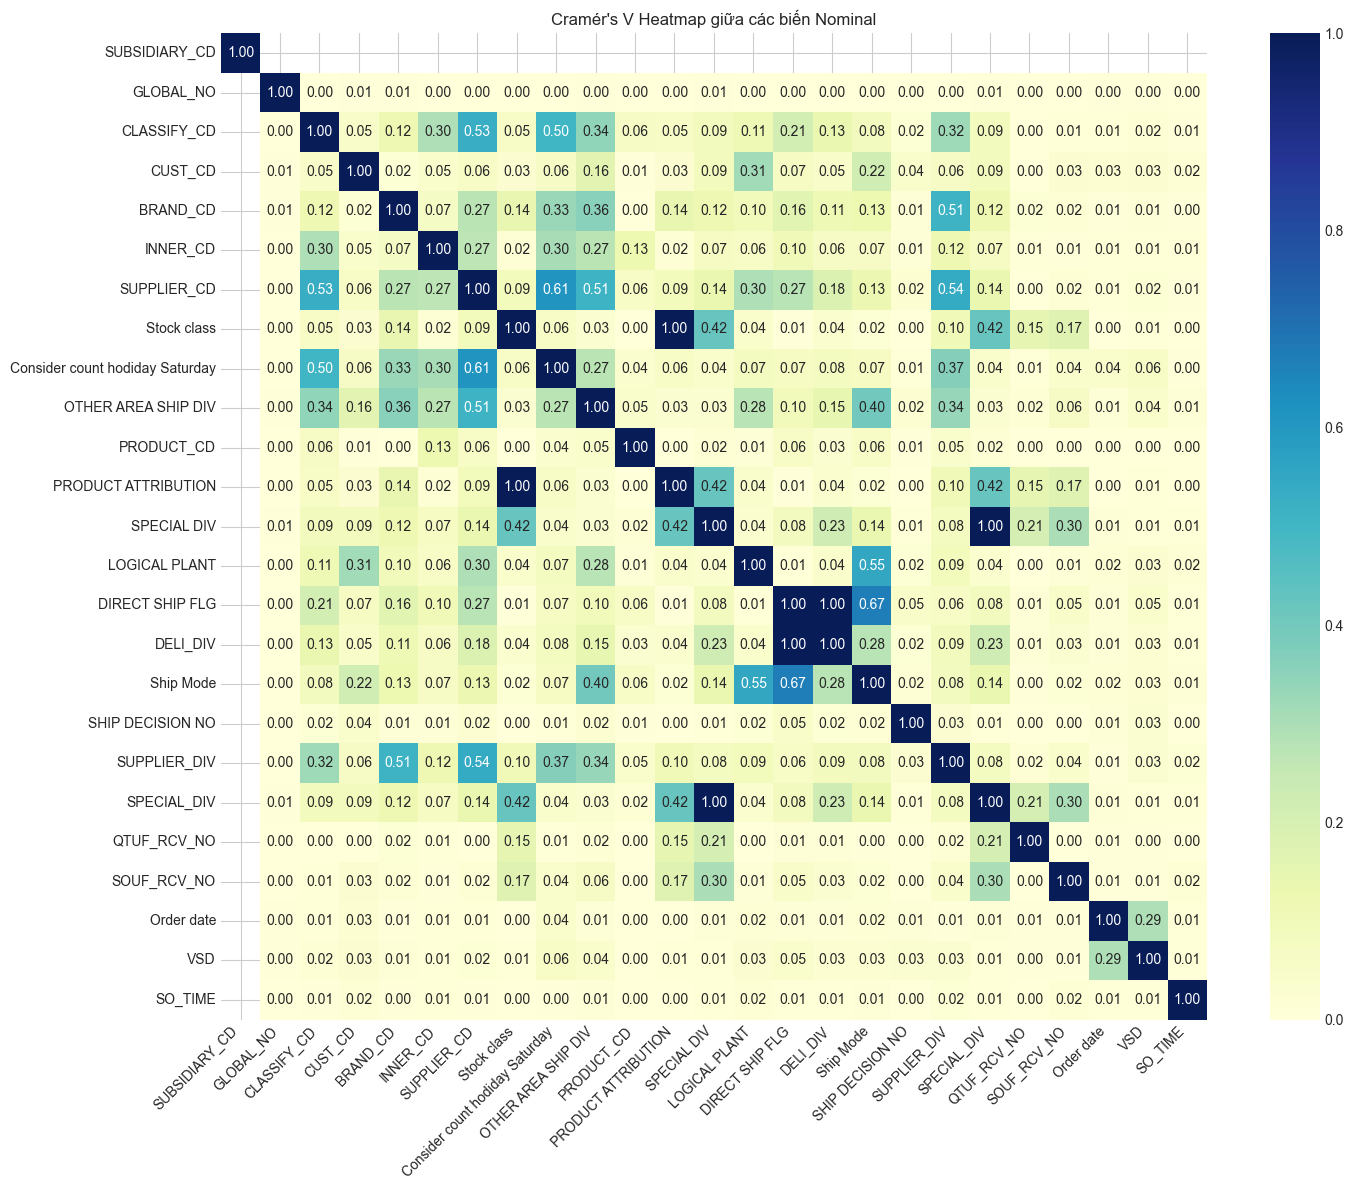

In [201]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import warnings

# Bỏ qua tất cả cảnh báo
warnings.filterwarnings("ignore")

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  # Bias correction
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

def reduce_cardinality(series, top_n=100, other_label='OTHER'):
    """
    Giữ lại top_n giá trị xuất hiện nhiều nhất trong một cột dạng category,
    gán các giá trị còn lại thành nhãn 'OTHER' (hoặc tên khác do bạn chỉ định).
    """
    top_categories = series.value_counts().nlargest(top_n).index
    return series.apply(lambda x: x if x in top_categories else other_label)

# Tạo ma trận Cramér's V cho các biến nominal
cramer_matrix_nominal = pd.DataFrame(
    np.zeros((len(nominal), len(nominal))),
    index=nominal,
    columns=nominal
)

# Giảm độ phân biệt của các biến nominal nếu cần
reduced_data_nominal = df_WoE_IV[nominal].copy()
for col in nominal:
    reduced_data_nominal[col] = reduce_cardinality(reduced_data_nominal[col], top_n=50)

# Tính giá trị Cramér's V cho từng cặp biến nominal
for col1 in nominal:
    for col2 in nominal:
        if col1 == col2:
            cramer_matrix_nominal.loc[col1, col2] = 1.0
        else:
            cramer_matrix_nominal.loc[col1, col2] = cramers_v(reduced_data_nominal[col1], reduced_data_nominal[col2])

# Vẽ heatmap cho ma trận Cramér's V
plt.figure(figsize=(15, 12))
sns.heatmap(cramer_matrix_nominal, annot=True, fmt=".2f", cmap="YlGnBu", square=True)
plt.title("Cramér's V Heatmap giữa các biến Nominal")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# **Building features**

Kết hợp visualize, IV, Spearman, Cramers'V em sẽ lọc tìm ra những feature phù hợp cho mô hình.

In [202]:
Weak_features = iv[iv['IV'] < 0.02]['Variable'].tolist()
Strong_features = iv[(iv['IV'] >= 0.02) & (iv['IV'] <= 0.8)]['Variable'].tolist()

In [203]:
for col in Strong_features:
    print(col)

Order date
DIRECT SHIP FLG
BRAND_CD
Ship Mode
WEIGHT PER PIECE
SUPPLIER_DIV
QTUF_RCV_NO
OTHER AREA SHIP DIV
SO_DAY_OF_MONTH
Consider count hodiday Saturday
SUPPLIER INV AMOUNT
PURCHASE AMOUNT
LOGICAL PLANT


In [204]:
full_data_7_9_cleaned['Sales order line number'].unique().max()

28

In [205]:
Potential_features.extend(['Order date', 'BRAND_CD','SO QTY','PURCHASE AMOUNT','WEIGHT PER PIECE','SO_DAY_OF_MONTH','label'])

In [206]:
for col in Potential_features:
    print(col)

Stock class
OTHER AREA SHIP DIV
SPECIAL DIV
LOGICAL PLANT
DELI_DIV
Ship Mode
SUPPLIER_DIV
Order date
BRAND_CD
SO QTY
PURCHASE AMOUNT
WEIGHT PER PIECE
SO_DAY_OF_MONTH
label


In [207]:
full_data_4_6['Order date'] = pd.to_datetime(full_data_4_6['Order date'])
full_data_7_9['Order date'] = pd.to_datetime(full_data_7_9['Order date'])

In [208]:
df_full_data = pd.concat([full_data_4_6, full_data_7_9], axis=0)
df_full_data_cleaned = pd.concat([full_data_4_6_cleaned, full_data_7_9_cleaned], axis=0)

In [209]:
Potential_features.append("CLASSIFY_CD")

In [210]:
Potential_features.append("PRODUCT ATTRIBUTION")
Potential_features.append("SO_TIME")
Potential_features.append("SO_DAY_OF_WEEK")
Potential_features.append("VSD")

In [211]:
# Remove all occurrences of each character in 'CLASSIFY_CD' from Potential_features if present
for char in list('CLASSIFY_CD'):
    if char in Potential_features:
        Potential_features.remove(char)

In [212]:
Potential_features

['Stock class',
 'OTHER AREA SHIP DIV',
 'SPECIAL DIV',
 'LOGICAL PLANT',
 'DELI_DIV',
 'Ship Mode',
 'SUPPLIER_DIV',
 'Order date',
 'BRAND_CD',
 'SO QTY',
 'PURCHASE AMOUNT',
 'WEIGHT PER PIECE',
 'SO_DAY_OF_MONTH',
 'label',
 'CLASSIFY_CD',
 'PRODUCT ATTRIBUTION',
 'SO_TIME',
 'SO_DAY_OF_WEEK',
 'VSD']

In [213]:
df_full_data = df_full_data[Potential_features]
full_data_4_6 = full_data_4_6[Potential_features]
full_data_7_9 = full_data_7_9[Potential_features]

df_full_data_cleaned = df_full_data_cleaned[Potential_features]
full_data_4_6_cleaned = full_data_4_6_cleaned[Potential_features]
full_data_7_9_cleaned = full_data_7_9_cleaned[Potential_features]

# **Xuất file**

In [214]:
df_full_data.to_csv('df_full_data.csv', index=False)
full_data_4_6.to_csv('full_data_4_6.csv', index=False)
full_data_7_9.to_csv('full_data_7_9.csv', index=False)

df_full_data_cleaned.to_csv('df_full_data_cleaned.csv', index=False)
full_data_4_6_cleaned.to_csv('full_data_4_6_cleaned.csv', index=False)
full_data_7_9_cleaned.to_csv('full_data_7_9_cleaned.csv', index=False)